<a href="https://colab.research.google.com/github/nusc2016/DS-Unit-2-Kaggle-Challenge/blob/master/Module4/Late/Aaron_Huizenga_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
import numpy as np
import plotly.express as px
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
test.shape

(14358, 40)

In [0]:
def wrangle(df):

  # Prevent error message
  X = df.copy()
  target='status_group'

  # Treat near-zero values like zero 
  X['latitude'] = X['latitude'].replace(-2e-08,0)

  # Replace zero values with nulls so we can impute later
  cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)
  
  # Drop super high unique value percentage values 
  X = X.drop(columns=['recorded_by','id'])

  # Convert date_recorded to datetime format so that we can calculate time between 
  # construction year and date recorded 
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  
  # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year

  # Engineer feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()
  
  # Find amount of water per person
  X['water/person'] = X['amount_tsh'].replace({0:1}) / X['population'].replace({0:1})
  
  # Find average population served per year 
  X['pop/year'] = X['population'].replace({0:1}) / X['years'].replace({0:1})

  X = X.drop(columns=['date_recorded'])

  # Return wrangled dataframe
  return X

In [0]:
# Apply feature engineering to train data 

train = wrangle(train)
test = wrangle(test)

In [0]:
# Write encoder function to preprocess the low cardinality features

def encoder(df):
  target = 'status_group'
  if target in df.columns:
    df_features = df.drop(columns=[target])
  else:
    df_features = df
  numeric_features = df_features.select_dtypes(include='number')
  categorical = df_features.select_dtypes(exclude='number').nunique()
  cat_features = categorical[categorical <=150].index.tolist()
  high_cardinality_features = pd.DataFrame(categorical[categorical > 150])
  df_high = df[high_cardinality_features.T.columns]
  one_hot_encode = ce.OneHotEncoder(use_cat_names=True)
  one_hot_encode.fit(df[cat_features])
  low_cardinality_features = one_hot_encode.transform(df[cat_features])
  df1 = numeric_features.join(low_cardinality_features, how='outer')
  df2 = df1.join(df_high, how='outer')


  return df2

In [0]:
X_train = encoder(train)

In [0]:
# Define target feature and split training dataset into training and validation sets 

target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [0]:
# Create the subsets for training validation and test datasets

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [0]:
# Create pipeline with Random Forest Classifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_jobs=-1))

In [0]:
# Fit the pipeline to the training data 

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

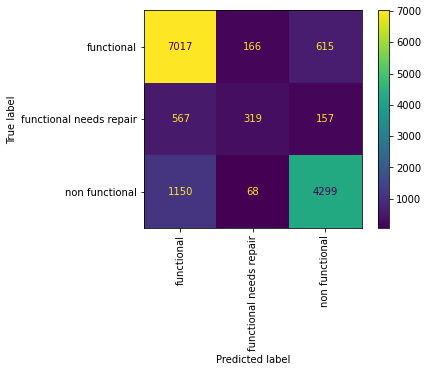

In [14]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='vertical', 
                      values_format='.0f');

In [0]:
# I will use the next function to run a predict on test

y_pred = pipeline.predict(X_test)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv("Aaron_Huizenga4.csv", index=False)

In [0]:
from google.colab import files
files.download('Aaron_Huizenga4.csv')